In [2]:
import tensorflow as tf 
import tensorflow_quantum as tfq

import cirq 
import sympy 
import numpy as np 
import seaborn as sns 
import collections 

# visualization tools
%matplotlib inline 
import matplotlib.pyplot as plt 
from cirq.contrib.svg import SVGCircuit 

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0, 1.0] range
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [4]:
print(y_train[0:9])

[5 0 4 1 9 2 1 3 1]


In [5]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [6]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


True


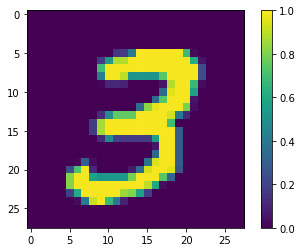

In [7]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

In [8]:
def create_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1))
    return model

In [9]:
model = create_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [10]:
model.fit(x_train,
    y_train,
    batch_size=128,
    epochs=1,
    verbose=1,
    validation_data=(x_test, y_test)
)

cnn_results = model.evaluate(x_test, y_test)

62/62 [==============================] - 1s 23ms/step - loss: 0.0041 - accuracy: 0.9990


In [11]:
def create_fair_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(4,4,1)))
    model.add(tf.keras.layers.Dense(2, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model

model = create_fair_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [12]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    # Determine the set of labels for each unique image:
    for x,y in zip(xs, ys):
        mapping[tuple(x.flatten())].add(y)

    new_x = []
    new_y = []
    for x,y in zip(xs, ys):
        labels = mapping[tuple(x.flatten())]
        if len(labels) == 1:
            new_x.append(x)
            new_y.append(list(labels)[0])
        else:
            # Throw out images that match more than one label. 
            pass
    
    num_3 = sum(1 for value in mapping.values() if True in value)
    num_6 = sum(1 for value in mapping.values() if False in value)
    num_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of 3s: ", num_3)
    print("Number of 6s: ", num_6)
    print("Number of contradictory images: ", num_both)
    print()
    print("Initial number of examples: ", len(xs))
    print("Remaining non-contradictory examples: ", len(new_x))

    return np.array(new_x), np.array(new_y)

x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)


THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

_ = remove_contradicting(x_train_bin, y_train_nocon)

Number of unique images: 10387
Number of 3s:  4961
Number of 6s:  5475
Number of contradictory images:  49

Initial number of examples:  12049
Remaining non-contradictory examples:  11520
Number of unique images: 193
Number of 3s:  124
Number of 6s:  113
Number of contradictory images:  44

Initial number of examples:  11520
Remaining non-contradictory examples:  3731


In [13]:
model.fit(x_train_bin, y_train_nocon,
        batch_size=128,
        epochs=20,
        verbose=2,
        validation_data=(x_test_bin, y_test))

fair_nn_results = model.evaluate(x_test_bin, y_test)

Epoch 1/20
90/90 - 0s - loss: 0.7396 - accuracy: 0.4739 - val_loss: 0.7030 - val_accuracy: 0.4903
Epoch 2/20
90/90 - 0s - loss: 0.6450 - accuracy: 0.5479 - val_loss: 0.6204 - val_accuracy: 0.5473
Epoch 3/20
90/90 - 0s - loss: 0.5601 - accuracy: 0.6413 - val_loss: 0.5295 - val_accuracy: 0.6159
Epoch 4/20
90/90 - 0s - loss: 0.4724 - accuracy: 0.7105 - val_loss: 0.4465 - val_accuracy: 0.7973
Epoch 5/20
90/90 - 0s - loss: 0.3978 - accuracy: 0.8381 - val_loss: 0.3783 - val_accuracy: 0.8201
Epoch 6/20
90/90 - 0s - loss: 0.3418 - accuracy: 0.8538 - val_loss: 0.3308 - val_accuracy: 0.8653
Epoch 7/20
90/90 - 0s - loss: 0.3028 - accuracy: 0.8767 - val_loss: 0.2984 - val_accuracy: 0.8664
Epoch 8/20
90/90 - 0s - loss: 0.2757 - accuracy: 0.8769 - val_loss: 0.2752 - val_accuracy: 0.8669
Epoch 9/20
90/90 - 0s - loss: 0.2565 - accuracy: 0.8772 - val_loss: 0.2593 - val_accuracy: 0.8669
Epoch 10/20
90/90 - 0s - loss: 0.2431 - accuracy: 0.8816 - val_loss: 0.2478 - val_accuracy: 0.9151
Epoch 11/20
90/90 -

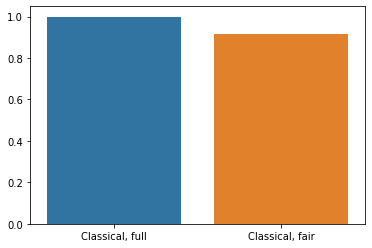

In [14]:
cnn_accuracy = cnn_results[1]
fair_nn_accuracy = fair_nn_results[1]

sns.barplot(["Classical, full", "Classical, fair"],
            [cnn_accuracy, fair_nn_accuracy])